In [1]:
import itertools
import pandas as pd
import seaborn as sns
import math
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

In [2]:
covid_by_province = pd.read_csv('./data/Разпределение по дата и по области.csv', parse_dates=["Дата"])
covid_by_province.head()

,Дата,BLG_ALL,BLG_ACT,BGS_ALL,BGS_ACT,VAR_ALL,VAR_ACT,VTR_ALL,VTR_ACT,VID_ALL,...,SZR_ALL,SZR_ACT,TGV_ALL,TGV_ACT,HKV_ALL,HKV_ACT,SHU_ALL,SHU_ACT,JAM_ALL,JAM_ACT
0,2020-06-06,144,76,54,4,26,0,29,11,190,...,40,7,1,0,30,8,13,9,161,105
1,2020-06-07,144,75,54,4,26,0,29,5,190,...,40,7,1,0,30,8,15,11,162,106
2,2020-06-08,146,79,54,4,26,0,29,5,190,...,40,7,1,0,30,8,15,10,162,106
3,2020-06-09,148,67,54,4,26,0,29,5,190,...,41,7,1,0,30,8,16,12,162,106
4,2020-06-10,148,67,56,4,26,0,29,5,190,...,41,7,1,0,30,8,28,24,163,106


# Arima

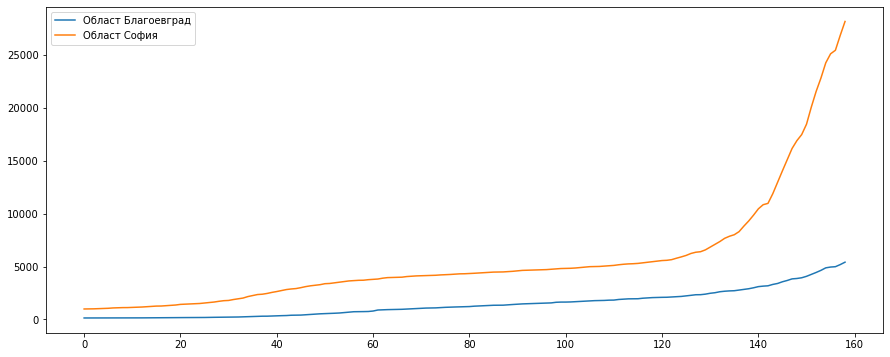

In [3]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15, 6)
plt.plot(covid_by_province['BLG_ALL'].values, label = "Област Благоевград")
plt.plot(covid_by_province['SOF_ALL'].values, label = "Област София")
plt.legend()

In [4]:
covid_by_province.rename(columns={'Дата':'date'}, inplace=True)

In [5]:
covid_by_province_transposed = covid_by_province.melt(id_vars='date', var_name = 'region', value_name='cases')

In [6]:
covid_by_province_transposed.head()

,date,region,cases
0,2020-06-06,BLG_ALL,144
1,2020-06-07,BLG_ALL,144
2,2020-06-08,BLG_ALL,146
3,2020-06-09,BLG_ALL,148
4,2020-06-10,BLG_ALL,148


## Cases distribution

### Moving avarige

A moving average (rolling average or running average) is a calculation to analyze data points by creating a series of averages of different subsets of the full data set. It is also called a moving mean or rolling mean and is a type of finite impulse response filter. 


In [7]:
sns.set(palette='Set1')

In [8]:
#Function for making a time series on a region and plotting the rolled mean and standard deviation
def roll(regions,case='cases'):
    test_s=covid_by_province_transposed.loc[(covid_by_province_transposed['region']==regions)]  
    test_s=test_s[['date',case]]
    test_s=test_s.set_index('date')
    test_s.astype('int64')
    a=len(test_s.loc[(test_s['cases']>=10)])
    test_s=test_s[-a:]
    return (test_s.rolling(window=4,center=False).mean().dropna())

In [9]:
def rollPlot(region, case='cases'):
    test_s=covid_by_province_transposed.loc[(covid_by_province_transposed['region']==region)]  
    test_s=test_s[['date',case]]
    test_s=test_s.set_index('date')
    test_s.astype('int64')
    a=len(test_s.loc[(test_s['cases']>=10)])
    test_s=test_s[-a:]
    plt.figure(figsize=(16,6))
    plt.plot(test_s.rolling(window=7,center=False).mean().dropna(),label='Rolling Mean')
    plt.plot(test_s[case], label = 'Cases')
    plt.plot(test_s.rolling(window=7,center=False).std(),label='Rolling std')
    plt.legend()
    plt.title('Cases distribution in %s with rolling mean and standard' %region)
    plt.xticks([])

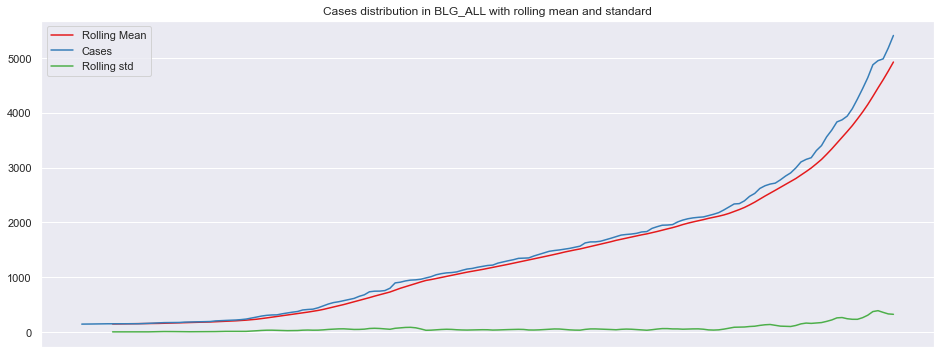

In [10]:
tsC1=roll('BLG_ALL')
rollPlot('BLG_ALL')

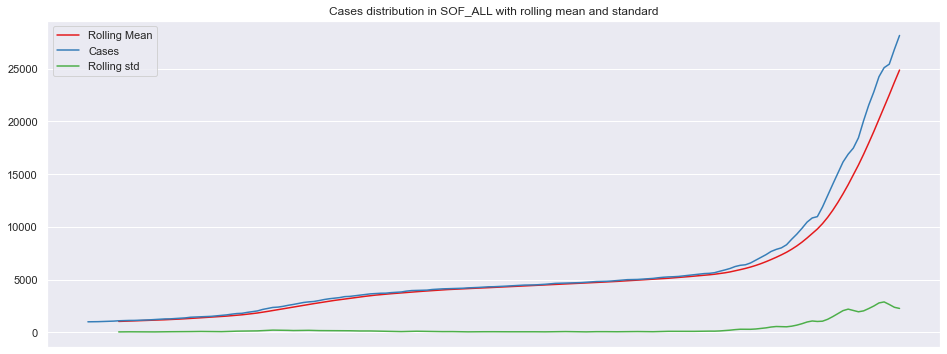

In [11]:
tsC2=roll('SOF_ALL')
rollPlot('SOF_ALL')

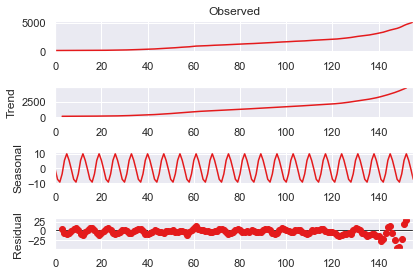

In [12]:
#Decomposing the data (ts) to find its properties
fig=sm.tsa.seasonal_decompose(tsC1.values,period=7).plot()

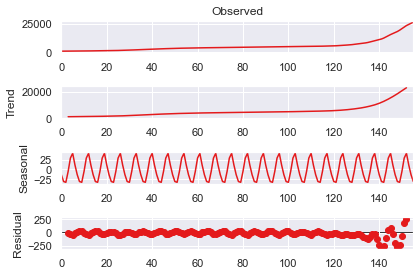

In [13]:
fig=sm.tsa.seasonal_decompose(tsC2.values,period=7).plot()

In [14]:
#Function to check if the time series is statinary using Dickey fuller test (adfuller) (Checking for number of differencing (d))
def stationarity(ts):
    print('Results of Dickey-Fuller Test:')
    test = adfuller(ts, autolag='AIC')
    results = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags','Number of Observations'])
    for i,val in test[4].items():
        results['Critical Value (%s)'%i] = val
    print (results)

In [15]:
tsCBLG=tsC1['cases'].values
stationarity(tsCBLG)

Results of Dickey-Fuller Test:
Test Statistic              0.826247
p-value                     0.992048
#Lags                      14.000000
Number of Observations    141.000000
Critical Value (1%)        -3.477601
Critical Value (5%)        -2.882266
Critical Value (10%)       -2.577822
dtype: float64


In [16]:
tsCSOF= tsC2['cases'].values
stationarity(tsCSOF)

Results of Dickey-Fuller Test:
Test Statistic              0.985487
p-value                     0.994110
#Lags                      13.000000
Number of Observations    142.000000
Critical Value (1%)        -3.477262
Critical Value (5%)        -2.882118
Critical Value (10%)       -2.577743
dtype: float64


## AUTO Correlation 
Autocorrelation(ACF) (q-values), also known as serial correlation, is the correlation of a signal with a delayed copy of itself as a function of delay. Informally, it is the similarity between observations as a function of the time lag between them. (An MA term is technically, the error of the lagged forecast.)

The required number of AR terms (p - value) can be found by inspecting the Partial Autocorrelation. The partial autocorrelation function (PACF) gives the partial correlation of a stationary time series with its own lagged values, regressed the values of the time series at all shorter lags. It contrasts with the autocorrelation function, which does not control for other lags. (It can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. PACF sort of conveys the pure correlation between a lag and the series.)

In [17]:
# AUTO Correlation 
def corr(ts):
    plot_acf(ts,lags=12,title="ACF")
    plot_pacf(ts,lags=12,title="PACF")

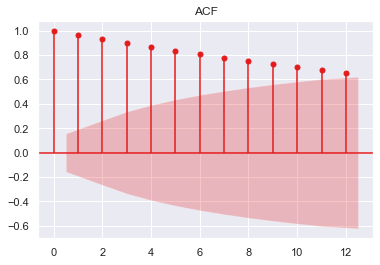

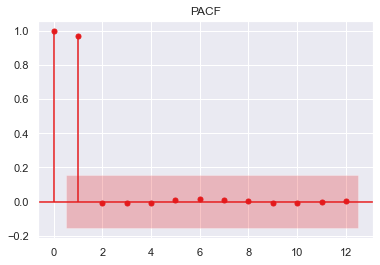

In [18]:
corr(tsCBLG)

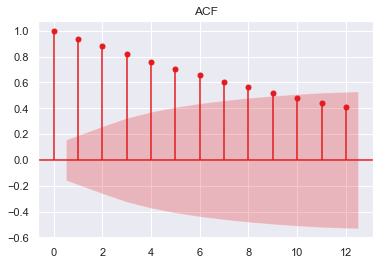

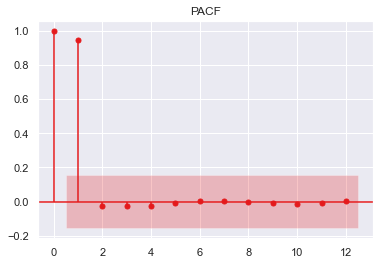

In [19]:
corr(tsCSOF)

## Model Building
#### An ARIMA model is characterized by 3 terms: p, d, q.
* p is the order of the AR ( Auto Regressive ) term
* q is the order of the MA ( Moving Average ) term
* d is the number of differencing required to make the time series stationary.

In [20]:
#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

#splitting 80%/20% because of little amount of data
def split(ts):
    size = int(len(ts) * math.log(0.80))
    train= ts[:size]
    test = ts[size:]
    return(train,test)

In [21]:
#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,7)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.7), end=int(len(ts) * 1.2))
    pred=result.forecast(steps=len(test))[0]
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(pred,c='blue', label= 'predictions')
    plt.plot(test, c='green',label='real values')
    plt.legend()
    plt.title('True values vs Predicted values')
    #Printing the error metrics
    print(result.summary())        
    
    print('\nMean absolute percentage error: %f'%mape(test,pred))
    return (pred)

### Results for Blagoevgrad

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  120
Model:                 ARIMA(2, 2, 6)   Log Likelihood                -299.655
Method:                       css-mle   S.D. of innovations              2.788
Date:                Wed, 25 Nov 2020   AIC                            619.311
Time:                        17:15:29   BIC                            647.186
Sample:                             2   HQIC                           630.631
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1888      0.130      1.450      0.147      -0.066       0.444
ar.L1.D2.y     1.2392      0.029     43.071      0.000       1.183       1.296
ar.L2.D2.y    -0.9648      0.024    -39.882      0.0

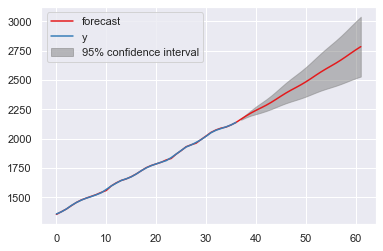

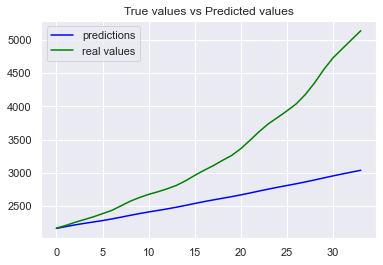

In [22]:
train,test=split(tsCBLG)
pred=arima(train,test)
plt.savefig('BLG')

### Results for Sofia

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  120
Model:                 ARIMA(2, 2, 6)   Log Likelihood                -355.183
Method:                       css-mle   S.D. of innovations              4.348
Date:                Wed, 25 Nov 2020   AIC                            730.367
Time:                        17:16:30   BIC                            758.241
Sample:                             2   HQIC                           741.687
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6749      0.625      1.079      0.281      -0.551       1.901
ar.L1.D2.y     1.2408      0.010    119.912      0.000       1.221       1.261
ar.L2.D2.y    -0.9915      0.012    -79.344      0.0

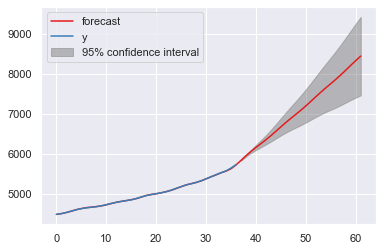

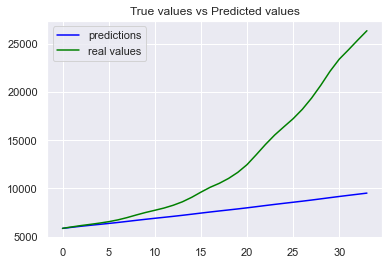

In [23]:
train,test=split(tsCSOF)
pred=arima(train,test)
plt.savefig('SOF')